In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from utils import *
import os

# do not change.
seed_everything(42)

<function matplotlib.pyplot.show(close=None, block=None)>

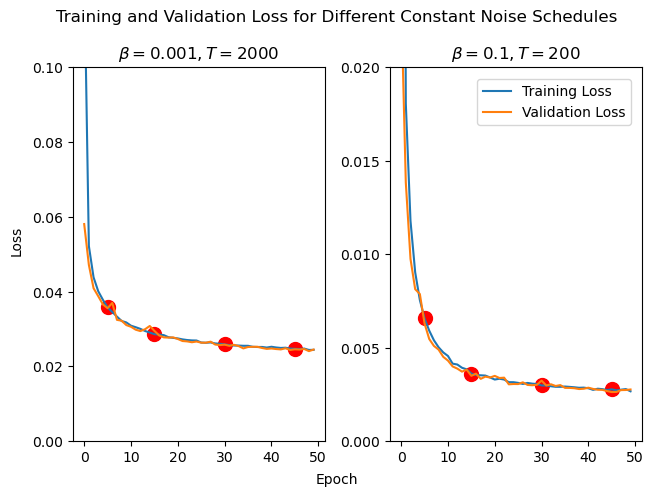

In [2]:
# Q1b train val loss curves
good_run_dir = "../runs/const_q1_good_run"
bad_run_dir = "../runs/const_q1_bad_run"

good_loss_csv = os.path.join(good_run_dir, "losses.csv")
bad_loss_csv = os.path.join(bad_run_dir, "losses.csv")

good_loss_df = pd.read_csv(good_loss_csv)
bad_loss_df = pd.read_csv(bad_loss_csv)

good_train_loss = good_loss_df["avg_training_loss"]
bad_train_loss = bad_loss_df["avg_training_loss"]

good_val_loss = good_loss_df["avg_validation_loss"]
bad_val_loss = bad_loss_df["avg_validation_loss"]


visualise_epochs = [5, 15, 30, 45]

fig, ax = plt.subplots(ncols=2)
ax[0].set_title(r"$\beta = 0.001, T=2000$")
ax[0].plot(
    good_train_loss,
)
ax[0].plot(
    good_val_loss,
)
ax[0].set_ylim([0, 0.1])

ax[1].set_title(r"$\beta = 0.1, T=200$")
ax[1].plot(bad_train_loss, label="Training Loss")
ax[1].plot(bad_val_loss, label="Validation Loss")
ax[1].set_ylim([0, 0.02])

for t in visualise_epochs:
    ax[0].scatter(t, good_train_loss[t], color="r", s=100)
    ax[1].scatter(t, bad_train_loss[t], color="r", s=100)

fig.legend(bbox_to_anchor=(0.97, 0.85))
# Set y ticks for bad run.
start = 0
end = 0.02
interval = 0.005
ticks = np.arange(start, end + interval, interval)
ax[1].set_yticks(ticks)

# Set common labels
fig.text(0.5, 0.0, "Epoch", ha="center", va="center")  # X-label
fig.text(0.0, 0.5, "Loss", ha="center", va="center", rotation="vertical")  # Y-label

fig.suptitle("Training and Validation Loss for Different Constant Noise Schedules")
plt.tight_layout()
plt.show
# plt.savefig("../report/figs/q1b_loss.png", bbox_inches="tight", dpi=300)

In [26]:
# Q1b conditional generation plots
import torch
import yaml
from accelerate import Accelerator
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Subset
from icecream import ic


accelerator = Accelerator()

good_config = os.path.join(good_run_dir, "config.yaml")
bad_config = os.path.join(bad_run_dir, "config.yaml")

with open(good_config, "r") as f:
    good_config = yaml.load(f, Loader=yaml.FullLoader)

with open(bad_config, "r") as f:
    bad_config = yaml.load(f, Loader=yaml.FullLoader)

# Time steps to visualise conditional generation process.
visualise_ts_1 = [100, 1000, 2000]
visualise_ts_2 = [10, 100, 200]

noise_schedule = fetch_noise_schedule(good_config["noise_schedule"])

# Load the different noise schedules.
good_T = good_config["T"]
bad_T = bad_config["T"]

good_beta_t, good_alpha_t = noise_schedule(
    good_T, **good_config["custom_noise_schedule_params"]
)
bad_beta_t, bad_alpha_t = noise_schedule(
    bad_T, **bad_config["custom_noise_schedule_params"]
)

# Initialise the diffusion model - both runs use the same models.
decoder_model_class = fetch_model(good_config["decoder_model"])
diffusion_model_class = fetch_model(good_config["diffusion_model"])

# Duplicate decoder to avoid both models sharing the same decoder instance.
decoder_1 = decoder_model_class(**good_config["decoder_model_params"])
decoder_2 = decoder_model_class(**good_config["decoder_model_params"])

good_model = diffusion_model_class(
    decoder_1, good_beta_t, good_alpha_t, accelerator.device
)
bad_model = diffusion_model_class(
    decoder_2, bad_beta_t, bad_alpha_t, accelerator.device
)


# Load the data - note this is done to ensure the same batch is visualised here as was
# saved in the training runs dir under samples/conditional at every epoch.

# TODO: check if plots are fine with random image from the val set.
pre_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (1.0))]
)

# Load the dataset.
dataset = MNIST("../data", train=True, download=True, transform=pre_transforms)

# Split the dataset into train and validation sets.
val_fraction = good_config["val_fraction"]
train_set, val_set = torch.utils.data.random_split(
    dataset, [1 - val_fraction, val_fraction]
)

# Initialise the dataloaders.
train_loader = DataLoader(
    train_set, batch_size=good_config["train_batch_size"], shuffle=True
)

val_loader = DataLoader(
    val_set,
    batch_size=good_config["val_batch_size"],
    shuffle=False,
)
val_loader, good_model, bad_model = accelerator.prepare(
    val_loader, good_model, bad_model
)
# Loop over all batches to get to first img of last batch.
for batch, _ in val_loader:
    _

good_samples = torch.zeros(
    len(visualise_epochs), 2 * (len(visualise_ts_1) + 1), 1, 28, 28
)
bad_samples = torch.zeros(
    len(visualise_epochs), 2 * (len(visualise_ts_2) + 1), 1, 28, 28
)

with torch.no_grad():
    good_model.eval()
    # bad_model.eval()
    for idx, epoch in enumerate(visualise_epochs):
        ic(epoch)
        # Load the epochs weights.
        good_model_path = os.path.join(
            good_run_dir, "model_weights", f"epoch_{epoch}_model.pth"
        )
        bad_model_path = os.path.join(
            bad_run_dir, "model_weights", f"epoch_{epoch}_model.pth"
        )

        good_model.load_state_dict(
            torch.load(good_model_path, map_location=accelerator.device)
        )
        bad_model.load_state_dict(
            torch.load(bad_model_path, map_location=accelerator.device)
        )

        good_z_t = good_model.cond_sample(
            x.unsqueeze(0), visualise_ts_1, accelerator.device
        )
        bad_z_t = bad_model.cond_sample(
            x.unsqueeze(0), visualise_ts_2, accelerator.device
        )

        good_samples[idx] = good_z_t
        bad_samples[idx] = bad_z_t


def add_epoch_labels(plt, visualise_epochs, fs=12):
    # get figure and axis, assume 28x28 image size and padding of 2 for now.
    # not a general function!
    fig = plt.gcf()
    ax = plt.gca()

    image_width = 28
    pad = 2
    hpad = image_width // 2

    for idx, epoch in enumerate(visualise_epochs):
        ax.text(
            (idx) * (image_width + pad) + hpad,
            -pad,
            f"Epoch {epoch}",
            ha="center",
            fontsize=fs,
        )
    return plt


good_z_t_all_epochs = torch.zeros(
    good_samples.shape[0] * good_samples.shape[1], 1, 28, 28
)
bad_z_t_all_epochs = torch.zeros(
    good_samples.shape[0] * good_samples.shape[1], 1, 28, 28
)

# Find a nice vectorised way to do this, but need to make the time dimension contiguous.
for t in range(good_samples.shape[1]):
    good_z_t_all_epochs[
        t * good_samples.shape[0] : (t + 1) * good_samples.shape[0]
    ] = good_samples[:, t]
    bad_z_t_all_epochs[
        t * good_samples.shape[0] : (t + 1) * good_samples.shape[0]
    ] = bad_samples[:, t]

fs = 16
good_plt = make_cond_samples_plot(
    good_z_t_all_epochs, visualise_ts_1, len(visualise_epochs)
)
title = r"$\beta = 0.001, T=2000$"
good_plt = add_epoch_labels(good_plt, visualise_epochs, fs)
good_plt.title(title, y=1.035, fontsize=fs + 2)
good_plt.savefig(
    "../report/figs/q1b_good_cond_samples.png", bbox_inches="tight", dpi=300
)

bad_plt = make_cond_samples_plot(
    bad_z_t_all_epochs, visualise_ts_2, len(visualise_epochs)
)
title = r"$\beta = 0.1, T=200$"
bad_plt = add_epoch_labels(bad_plt, visualise_epochs, fs)
bad_plt.title(title, y=1.035, fontsize=fs + 2)
bad_plt.savefig("../report/figs/q1b_bad_cond_samples.png", bbox_inches="tight", dpi=300)

ic| epoch: 5
ic| epoch: 15
ic| epoch: 30
ic| epoch: 45


ic| epoch: 5
ic| epoch: 15
ic| epoch: 30
ic| epoch: 45


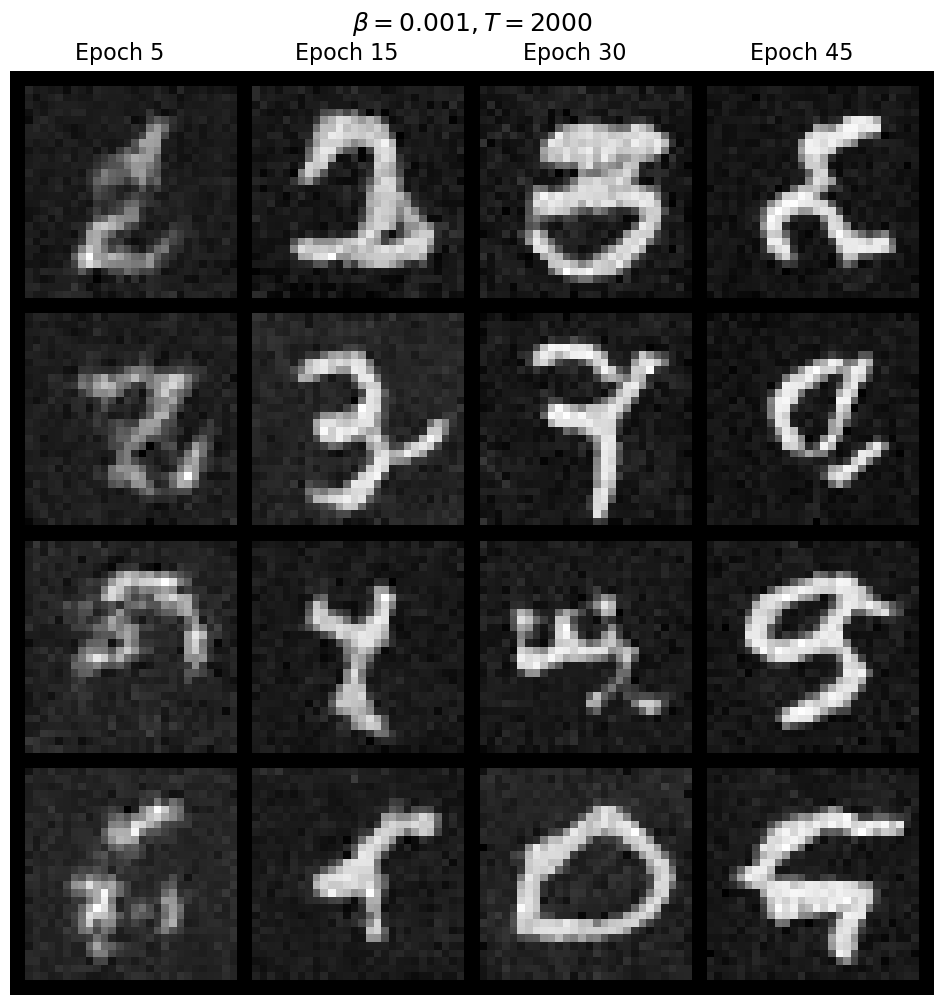

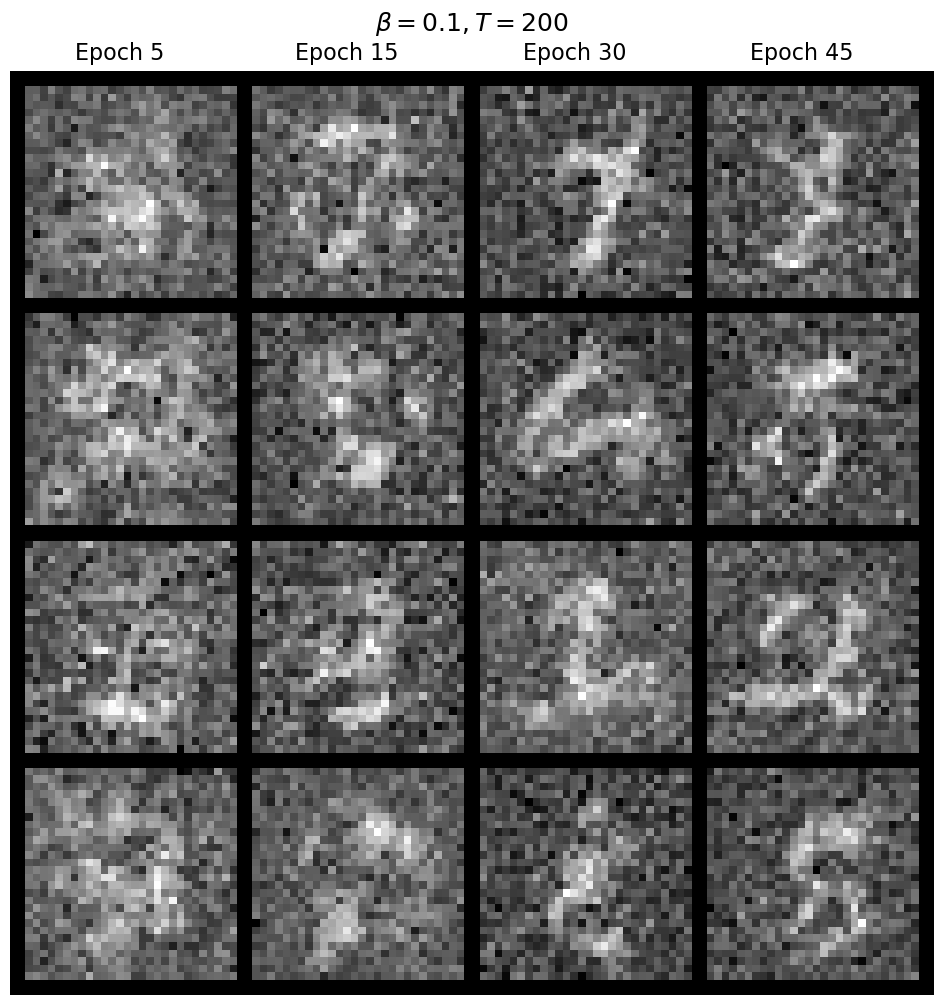

In [25]:
# Q1b unconditional generation plots
n_samples = 4
good_samples = torch.zeros(len(visualise_epochs), n_samples, *x.shape)
bad_samples = torch.zeros(len(visualise_epochs), n_samples, *x.shape)

with torch.no_grad():
    good_model.eval()
    # bad_model.eval()
    for idx, epoch in enumerate(visualise_epochs):
        ic(epoch)
        # Load the epochs weights.
        good_model_path = os.path.join(
            good_run_dir, "model_weights", f"epoch_{epoch}_model.pth"
        )
        bad_model_path = os.path.join(
            bad_run_dir, "model_weights", f"epoch_{epoch}_model.pth"
        )

        good_model.load_state_dict(
            torch.load(good_model_path, map_location=accelerator.device)
        )
        bad_model.load_state_dict(
            torch.load(bad_model_path, map_location=accelerator.device)
        )

        good_z_t = good_model.uncond_sample(n_samples, x.shape, accelerator.device)
        bad_z_t = bad_model.uncond_sample(n_samples, x.shape, accelerator.device)

        good_samples[idx] = good_z_t
        bad_samples[idx] = bad_z_t

good_z_t_all_epochs = torch.zeros(
    good_samples.shape[0] * good_samples.shape[1], *x.shape
)
bad_z_t_all_epochs = torch.zeros(
    good_samples.shape[0] * good_samples.shape[1], *x.shape
)

# Find a nice vectorised way to do this, but need to make the time dimension contiguous.
for t in range(good_samples.shape[1]):
    good_z_t_all_epochs[
        t * good_samples.shape[0] : (t + 1) * good_samples.shape[0]
    ] = good_samples[:, t]
    bad_z_t_all_epochs[
        t * good_samples.shape[0] : (t + 1) * good_samples.shape[0]
    ] = bad_samples[:, t]


good_plt = make_uncond_samples_plot(good_z_t_all_epochs, len(visualise_epochs))
title = r"$\beta = 0.001, T=2000$"
good_plt = add_epoch_labels(good_plt, visualise_epochs, fs)
good_plt.title(title, y=1.035, fontsize=18)
good_plt.savefig(
    "../report/figs/q1b_good_uncond_samples.png", bbox_inches="tight", dpi=300
)

bad_plt = make_uncond_samples_plot(bad_z_t_all_epochs, len(visualise_epochs))
title = r"$\beta = 0.1, T=200$"
bad_plt = add_epoch_labels(bad_plt, visualise_epochs, fs)
bad_plt.title(title, y=1.035, fontsize=18)
bad_plt.savefig(
    "../report/figs/q1b_bad_uncond_samples.png", bbox_inches="tight", dpi=300
)